In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-08 08:51:48.916032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 08:51:48.916090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-08 08:51:55.256882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 08:51:55.256937: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 08:51:55.256967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-08 08:51:55.257287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 3s 27ms/step - loss: 0.7348 - accuracy: 0.4937 - auc: 0.4002 - val_loss: 0.7146 - val_accuracy: 0.4895 - val_auc: 0.3437
Epoch 2/394
39/39 [==============================] - 1s 14ms/step - loss: 0.7252 - accuracy: 0.4977 - auc: 0.4223 - val_loss: 0.7080 - val_accuracy: 0.4868 - val_auc: 0.3806
Epoch 3/394
39/39 [==============================] - 0s 13ms/step - loss: 0.7166 - accuracy: 0.4915 - auc: 0.4461 - val_loss: 0.7026 - val_accuracy: 0.4888 - val_auc: 0.4190
Epoch 4/394
39/39 [==============================] - 1s 14ms/step - loss: 0.7113 - accuracy: 0.4991 - auc: 0.4620 - val_loss: 0.6982 - val_accuracy: 0.4823 - val_auc: 0.4571
Epoch 5/394
39/39 [==============================] - 0s 7ms/step - loss: 0.7054 - accuracy: 0.4995 - auc: 0.4798 - val_loss: 0.6945 - val_accuracy: 0.4827 - val_auc: 0.4941
Epoch 6/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6992 - accuracy: 0.5028 - auc: 0.5032 - val_loss: 0.6916 - val_accur

39/39 [==============================] - 0s 8ms/step - loss: 0.6664 - accuracy: 0.5398 - auc: 0.6840 - val_loss: 0.6608 - val_accuracy: 0.5171 - val_auc: 0.8289
Epoch 49/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6641 - accuracy: 0.5396 - auc: 0.6919 - val_loss: 0.6602 - val_accuracy: 0.5177 - val_auc: 0.8304
Epoch 50/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6638 - accuracy: 0.5426 - auc: 0.6929 - val_loss: 0.6597 - val_accuracy: 0.5183 - val_auc: 0.8321
Epoch 51/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6630 - accuracy: 0.5432 - auc: 0.6964 - val_loss: 0.6591 - val_accuracy: 0.5188 - val_auc: 0.8337
Epoch 52/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6646 - accuracy: 0.5426 - auc: 0.6880 - val_loss: 0.6586 - val_accuracy: 0.5195 - val_auc: 0.8351
Epoch 53/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6637 - accuracy: 0.5463 - auc: 0.6915 - val_loss: 0.6580 - val_accu

39/39 [==============================] - 1s 13ms/step - loss: 0.6330 - accuracy: 0.6245 - auc: 0.7619 - val_loss: 0.6246 - val_accuracy: 0.6340 - val_auc: 0.8772
Epoch 96/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6326 - accuracy: 0.6269 - auc: 0.7607 - val_loss: 0.6234 - val_accuracy: 0.6372 - val_auc: 0.8778
Epoch 97/394
39/39 [==============================] - 0s 10ms/step - loss: 0.6337 - accuracy: 0.6257 - auc: 0.7560 - val_loss: 0.6223 - val_accuracy: 0.6434 - val_auc: 0.8783
Epoch 98/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6311 - accuracy: 0.6325 - auc: 0.7654 - val_loss: 0.6211 - val_accuracy: 0.6489 - val_auc: 0.8788
Epoch 99/394
39/39 [==============================] - 1s 14ms/step - loss: 0.6302 - accuracy: 0.6326 - auc: 0.7636 - val_loss: 0.6199 - val_accuracy: 0.6532 - val_auc: 0.8795
Epoch 100/394
39/39 [==============================] - 1s 13ms/step - loss: 0.6292 - accuracy: 0.6449 - auc: 0.7663 - val_loss: 0.6187 - val

Epoch 142/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5707 - accuracy: 0.7222 - auc: 0.8151 - val_loss: 0.5460 - val_accuracy: 0.7994 - val_auc: 0.9088
Epoch 143/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5742 - accuracy: 0.7160 - auc: 0.8084 - val_loss: 0.5439 - val_accuracy: 0.8011 - val_auc: 0.9094
Epoch 144/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5703 - accuracy: 0.7180 - auc: 0.8118 - val_loss: 0.5418 - val_accuracy: 0.8025 - val_auc: 0.9102
Epoch 145/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5699 - accuracy: 0.7211 - auc: 0.8112 - val_loss: 0.5398 - val_accuracy: 0.8044 - val_auc: 0.9106
Epoch 146/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5652 - accuracy: 0.7278 - auc: 0.8170 - val_loss: 0.5377 - val_accuracy: 0.8067 - val_auc: 0.9111
Epoch 147/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5653 - accuracy: 0.7287 - auc: 0.8157 - val_loss

Epoch 189/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5013 - accuracy: 0.7656 - auc: 0.8503 - val_loss: 0.4502 - val_accuracy: 0.8500 - val_auc: 0.9342
Epoch 190/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5016 - accuracy: 0.7654 - auc: 0.8507 - val_loss: 0.4485 - val_accuracy: 0.8505 - val_auc: 0.9347
Epoch 191/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4933 - accuracy: 0.7736 - auc: 0.8579 - val_loss: 0.4464 - val_accuracy: 0.8509 - val_auc: 0.9351
Epoch 192/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4938 - accuracy: 0.7743 - auc: 0.8575 - val_loss: 0.4446 - val_accuracy: 0.8515 - val_auc: 0.9356
Epoch 193/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4957 - accuracy: 0.7687 - auc: 0.8535 - val_loss: 0.4425 - val_accuracy: 0.8521 - val_auc: 0.9359
Epoch 194/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4947 - accuracy: 0.7734 - auc: 0.8543 - val_loss

Epoch 236/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4449 - accuracy: 0.7946 - auc: 0.8801 - val_loss: 0.3808 - val_accuracy: 0.8664 - val_auc: 0.9488
Epoch 237/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4427 - accuracy: 0.7974 - auc: 0.8819 - val_loss: 0.3799 - val_accuracy: 0.8658 - val_auc: 0.9491
Epoch 238/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4398 - accuracy: 0.7978 - auc: 0.8833 - val_loss: 0.3785 - val_accuracy: 0.8662 - val_auc: 0.9493
Epoch 239/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4419 - accuracy: 0.7930 - auc: 0.8809 - val_loss: 0.3767 - val_accuracy: 0.8670 - val_auc: 0.9495
Epoch 240/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4453 - accuracy: 0.7962 - auc: 0.8787 - val_loss: 0.3758 - val_accuracy: 0.8673 - val_auc: 0.9497
Epoch 241/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4412 - accuracy: 0.7966 - auc: 0.8823 - val_loss

Epoch 283/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4112 - accuracy: 0.8069 - auc: 0.8953 - val_loss: 0.3418 - val_accuracy: 0.8723 - val_auc: 0.9561
Epoch 284/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4114 - accuracy: 0.8113 - auc: 0.8953 - val_loss: 0.3412 - val_accuracy: 0.8723 - val_auc: 0.9562
Epoch 285/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4197 - accuracy: 0.8054 - auc: 0.8898 - val_loss: 0.3401 - val_accuracy: 0.8730 - val_auc: 0.9563
Epoch 286/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4104 - accuracy: 0.8086 - auc: 0.8958 - val_loss: 0.3395 - val_accuracy: 0.8735 - val_auc: 0.9564
Epoch 287/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4093 - accuracy: 0.8107 - auc: 0.8967 - val_loss: 0.3390 - val_accuracy: 0.8735 - val_auc: 0.9565
Epoch 288/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4114 - accuracy: 0.8116 - auc: 0.8955 - val_loss

Epoch 330/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3825 - accuracy: 0.8240 - auc: 0.9096 - val_loss: 0.3208 - val_accuracy: 0.8740 - val_auc: 0.9595
Epoch 331/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3893 - accuracy: 0.8217 - auc: 0.9059 - val_loss: 0.3207 - val_accuracy: 0.8741 - val_auc: 0.9596
Epoch 332/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3909 - accuracy: 0.8187 - auc: 0.9046 - val_loss: 0.3219 - val_accuracy: 0.8733 - val_auc: 0.9597
Epoch 333/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3940 - accuracy: 0.8184 - auc: 0.9035 - val_loss: 0.3206 - val_accuracy: 0.8740 - val_auc: 0.9597
Epoch 334/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3845 - accuracy: 0.8234 - auc: 0.9087 - val_loss: 0.3209 - val_accuracy: 0.8738 - val_auc: 0.9598
Epoch 335/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3890 - accuracy: 0.8181 - auc: 0.9058 - val_loss

Epoch 377/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3716 - accuracy: 0.8298 - auc: 0.9147 - val_loss: 0.3158 - val_accuracy: 0.8705 - val_auc: 0.9615
Epoch 378/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3725 - accuracy: 0.8266 - auc: 0.9136 - val_loss: 0.3153 - val_accuracy: 0.8708 - val_auc: 0.9615
Epoch 379/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3711 - accuracy: 0.8279 - auc: 0.9147 - val_loss: 0.3151 - val_accuracy: 0.8712 - val_auc: 0.9616
Epoch 380/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8324 - auc: 0.9151 - val_loss: 0.3141 - val_accuracy: 0.8719 - val_auc: 0.9616
Epoch 381/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3690 - accuracy: 0.8336 - auc: 0.9156 - val_loss: 0.3131 - val_accuracy: 0.8729 - val_auc: 0.9616
Epoch 382/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3704 - accuracy: 0.8315 - auc: 0.9150 - val_loss

39/39 [==============================] - 0s 8ms/step - loss: 0.6513 - accuracy: 0.5873 - auc: 0.7196 - val_loss: 0.6415 - val_accuracy: 0.5743 - val_auc: 0.8618
Epoch 29/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6494 - accuracy: 0.5830 - auc: 0.7264 - val_loss: 0.6402 - val_accuracy: 0.5785 - val_auc: 0.8637
Epoch 30/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6472 - accuracy: 0.5935 - auc: 0.7286 - val_loss: 0.6389 - val_accuracy: 0.5852 - val_auc: 0.8652
Epoch 31/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6443 - accuracy: 0.5977 - auc: 0.7380 - val_loss: 0.6375 - val_accuracy: 0.5887 - val_auc: 0.8667
Epoch 32/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6455 - accuracy: 0.5931 - auc: 0.7317 - val_loss: 0.6361 - val_accuracy: 0.5936 - val_auc: 0.8684
Epoch 33/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6415 - accuracy: 0.6025 - auc: 0.7464 - val_loss: 0.6346 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.5782 - accuracy: 0.7133 - auc: 0.8061 - val_loss: 0.5491 - val_accuracy: 0.8065 - val_auc: 0.9090
Epoch 76/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5757 - accuracy: 0.7161 - auc: 0.8066 - val_loss: 0.5463 - val_accuracy: 0.8084 - val_auc: 0.9102
Epoch 77/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5715 - accuracy: 0.7209 - auc: 0.8126 - val_loss: 0.5440 - val_accuracy: 0.8120 - val_auc: 0.9108
Epoch 78/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5718 - accuracy: 0.7142 - auc: 0.8082 - val_loss: 0.5414 - val_accuracy: 0.8140 - val_auc: 0.9114
Epoch 79/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5690 - accuracy: 0.7179 - auc: 0.8108 - val_loss: 0.5389 - val_accuracy: 0.8154 - val_auc: 0.9122
Epoch 80/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5663 - accuracy: 0.7235 - auc: 0.8139 - val_loss: 0.5364 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.4882 - accuracy: 0.7750 - auc: 0.8590 - val_loss: 0.4322 - val_accuracy: 0.8558 - val_auc: 0.9406
Epoch 123/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4881 - accuracy: 0.7697 - auc: 0.8576 - val_loss: 0.4309 - val_accuracy: 0.8553 - val_auc: 0.9410
Epoch 124/394
39/39 [==============================] - 0s 11ms/step - loss: 0.4875 - accuracy: 0.7727 - auc: 0.8564 - val_loss: 0.4288 - val_accuracy: 0.8561 - val_auc: 0.9414
Epoch 125/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4825 - accuracy: 0.7758 - auc: 0.8615 - val_loss: 0.4265 - val_accuracy: 0.8568 - val_auc: 0.9420
Epoch 126/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4820 - accuracy: 0.7745 - auc: 0.8625 - val_loss: 0.4232 - val_accuracy: 0.8580 - val_auc: 0.9424
Epoch 127/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4795 - accuracy: 0.7719 - auc: 0.8624 - val_loss: 0.4206 - va

Epoch 169/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4352 - accuracy: 0.7964 - auc: 0.8830 - val_loss: 0.3593 - val_accuracy: 0.8702 - val_auc: 0.9549
Epoch 170/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4276 - accuracy: 0.8010 - auc: 0.8880 - val_loss: 0.3586 - val_accuracy: 0.8706 - val_auc: 0.9551
Epoch 171/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4245 - accuracy: 0.8036 - auc: 0.8904 - val_loss: 0.3572 - val_accuracy: 0.8711 - val_auc: 0.9552
Epoch 172/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4324 - accuracy: 0.7984 - auc: 0.8836 - val_loss: 0.3561 - val_accuracy: 0.8714 - val_auc: 0.9554
Epoch 173/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4192 - accuracy: 0.8083 - auc: 0.8936 - val_loss: 0.3546 - val_accuracy: 0.8719 - val_auc: 0.9556
Epoch 174/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4261 - accuracy: 0.8027 - auc: 0.8883 - val_los

Epoch 216/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4007 - accuracy: 0.8150 - auc: 0.8999 - val_loss: 0.3263 - val_accuracy: 0.8731 - val_auc: 0.9606
Epoch 217/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3983 - accuracy: 0.8152 - auc: 0.9013 - val_loss: 0.3242 - val_accuracy: 0.8744 - val_auc: 0.9606
Epoch 218/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3989 - accuracy: 0.8133 - auc: 0.9012 - val_loss: 0.3247 - val_accuracy: 0.8738 - val_auc: 0.9607
Epoch 219/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3949 - accuracy: 0.8146 - auc: 0.9034 - val_loss: 0.3260 - val_accuracy: 0.8729 - val_auc: 0.9607
Epoch 220/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3953 - accuracy: 0.8173 - auc: 0.9027 - val_loss: 0.3252 - val_accuracy: 0.8730 - val_auc: 0.9608
Epoch 221/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3935 - accuracy: 0.8165 - auc: 0.9036 - val_loss

Epoch 263/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3854 - accuracy: 0.8267 - auc: 0.9073 - val_loss: 0.3142 - val_accuracy: 0.8720 - val_auc: 0.9628
Epoch 264/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3804 - accuracy: 0.8210 - auc: 0.9100 - val_loss: 0.3139 - val_accuracy: 0.8719 - val_auc: 0.9628
Epoch 265/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3758 - accuracy: 0.8281 - auc: 0.9125 - val_loss: 0.3156 - val_accuracy: 0.8701 - val_auc: 0.9628
Epoch 266/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3746 - accuracy: 0.8267 - auc: 0.9128 - val_loss: 0.3152 - val_accuracy: 0.8704 - val_auc: 0.9629
Epoch 267/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3721 - accuracy: 0.8286 - auc: 0.9141 - val_loss: 0.3135 - val_accuracy: 0.8715 - val_auc: 0.9629
Epoch 268/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3737 - accuracy: 0.8262 - auc: 0.9132 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3576 - accuracy: 0.8390 - auc: 0.9205 - val_loss: 0.3121 - val_accuracy: 0.8663 - val_auc: 0.9637
Epoch 311/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3667 - accuracy: 0.8320 - auc: 0.9161 - val_loss: 0.3134 - val_accuracy: 0.8651 - val_auc: 0.9637
Epoch 312/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3609 - accuracy: 0.8371 - auc: 0.9196 - val_loss: 0.3124 - val_accuracy: 0.8658 - val_auc: 0.9638
Epoch 313/394
39/39 [==============================] - 0s 11ms/step - loss: 0.3576 - accuracy: 0.8360 - auc: 0.9209 - val_loss: 0.3098 - val_accuracy: 0.8676 - val_auc: 0.9638
Epoch 314/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3647 - accuracy: 0.8335 - auc: 0.9172 - val_loss: 0.3120 - val_accuracy: 0.8656 - val_auc: 0.9638
Epoch 315/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3639 - accuracy: 0.8314 - auc: 0.9176 - val_los

Epoch 357/394
39/39 [==============================] - 1s 14ms/step - loss: 0.3477 - accuracy: 0.8415 - auc: 0.9253 - val_loss: 0.3156 - val_accuracy: 0.8593 - val_auc: 0.9644
Epoch 358/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3479 - accuracy: 0.8427 - auc: 0.9253 - val_loss: 0.3165 - val_accuracy: 0.8581 - val_auc: 0.9644
Epoch 359/394
39/39 [==============================] - 1s 14ms/step - loss: 0.3486 - accuracy: 0.8447 - auc: 0.9246 - val_loss: 0.3175 - val_accuracy: 0.8571 - val_auc: 0.9644
Epoch 360/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3590 - accuracy: 0.8341 - auc: 0.9204 - val_loss: 0.3169 - val_accuracy: 0.8575 - val_auc: 0.9644
Epoch 361/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3471 - accuracy: 0.8402 - auc: 0.9260 - val_loss: 0.3162 - val_accuracy: 0.8580 - val_auc: 0.9644
Epoch 362/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3469 - accuracy: 0.8421 - auc: 0.9254 - val_lo

39/39 [==============================] - 0s 8ms/step - loss: 0.6660 - accuracy: 0.5502 - auc: 0.6659 - val_loss: 0.6585 - val_accuracy: 0.5600 - val_auc: 0.7957
Epoch 9/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6640 - accuracy: 0.5560 - auc: 0.6760 - val_loss: 0.6567 - val_accuracy: 0.5638 - val_auc: 0.8050
Epoch 10/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6616 - accuracy: 0.5532 - auc: 0.6830 - val_loss: 0.6550 - val_accuracy: 0.5702 - val_auc: 0.8118
Epoch 11/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6595 - accuracy: 0.5607 - auc: 0.6901 - val_loss: 0.6533 - val_accuracy: 0.5764 - val_auc: 0.8193
Epoch 12/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6584 - accuracy: 0.5657 - auc: 0.6948 - val_loss: 0.6517 - val_accuracy: 0.5847 - val_auc: 0.8252
Epoch 13/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6602 - accuracy: 0.5631 - auc: 0.6884 - val_loss: 0.6502 - val_accur

39/39 [==============================] - 0s 8ms/step - loss: 0.5832 - accuracy: 0.7063 - auc: 0.8027 - val_loss: 0.5632 - val_accuracy: 0.8202 - val_auc: 0.9097
Epoch 56/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5812 - accuracy: 0.7135 - auc: 0.8072 - val_loss: 0.5607 - val_accuracy: 0.8216 - val_auc: 0.9106
Epoch 57/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5816 - accuracy: 0.7123 - auc: 0.8019 - val_loss: 0.5582 - val_accuracy: 0.8235 - val_auc: 0.9117
Epoch 58/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5759 - accuracy: 0.7188 - auc: 0.8110 - val_loss: 0.5554 - val_accuracy: 0.8249 - val_auc: 0.9131
Epoch 59/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5764 - accuracy: 0.7151 - auc: 0.8089 - val_loss: 0.5527 - val_accuracy: 0.8268 - val_auc: 0.9141
Epoch 60/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5738 - accuracy: 0.7206 - auc: 0.8111 - val_loss: 0.5502 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.4785 - accuracy: 0.7812 - auc: 0.8681 - val_loss: 0.4402 - val_accuracy: 0.8515 - val_auc: 0.9455
Epoch 103/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4766 - accuracy: 0.7810 - auc: 0.8690 - val_loss: 0.4385 - val_accuracy: 0.8508 - val_auc: 0.9460
Epoch 104/394
39/39 [==============================] - 1s 13ms/step - loss: 0.4815 - accuracy: 0.7754 - auc: 0.8630 - val_loss: 0.4370 - val_accuracy: 0.8494 - val_auc: 0.9464
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4784 - accuracy: 0.7803 - auc: 0.8656 - val_loss: 0.4344 - val_accuracy: 0.8508 - val_auc: 0.9469
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4729 - accuracy: 0.7831 - auc: 0.8694 - val_loss: 0.4302 - val_accuracy: 0.8531 - val_auc: 0.9473
Epoch 107/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4762 - accuracy: 0.7774 - auc: 0.8654 - val_loss: 0.4288 - va

Epoch 149/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4204 - accuracy: 0.8052 - auc: 0.8918 - val_loss: 0.3685 - val_accuracy: 0.8543 - val_auc: 0.9587
Epoch 150/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4115 - accuracy: 0.8093 - auc: 0.8979 - val_loss: 0.3683 - val_accuracy: 0.8533 - val_auc: 0.9589
Epoch 151/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4151 - accuracy: 0.8084 - auc: 0.8947 - val_loss: 0.3664 - val_accuracy: 0.8544 - val_auc: 0.9590
Epoch 152/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4159 - accuracy: 0.8072 - auc: 0.8942 - val_loss: 0.3670 - val_accuracy: 0.8525 - val_auc: 0.9591
Epoch 153/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4141 - accuracy: 0.8081 - auc: 0.8955 - val_loss: 0.3650 - val_accuracy: 0.8537 - val_auc: 0.9593
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4088 - accuracy: 0.8096 - auc: 0.8983 - val_loss

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3784 - accuracy: 0.8264 - auc: 0.9119 - val_loss: 0.3423 - val_accuracy: 0.8509 - val_auc: 0.9628
Epoch 197/394
39/39 [==============================] - 0s 11ms/step - loss: 0.3803 - accuracy: 0.8255 - auc: 0.9111 - val_loss: 0.3429 - val_accuracy: 0.8501 - val_auc: 0.9629
Epoch 198/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3821 - accuracy: 0.8232 - auc: 0.9094 - val_loss: 0.3437 - val_accuracy: 0.8494 - val_auc: 0.9630
Epoch 199/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3821 - accuracy: 0.8237 - auc: 0.9102 - val_loss: 0.3429 - val_accuracy: 0.8500 - val_auc: 0.9629
Epoch 200/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3771 - accuracy: 0.8270 - auc: 0.9116 - val_loss: 0.3432 - val_accuracy: 0.8493 - val_auc: 0.9629
Epoch 201/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3761 - accuracy: 0.8271 - auc: 0.9127 - val_los

Epoch 243/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3637 - accuracy: 0.8306 - auc: 0.9179 - val_loss: 0.3417 - val_accuracy: 0.8418 - val_auc: 0.9640
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3573 - accuracy: 0.8379 - auc: 0.9214 - val_loss: 0.3448 - val_accuracy: 0.8396 - val_auc: 0.9640
Epoch 245/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3555 - accuracy: 0.8372 - auc: 0.9219 - val_loss: 0.3430 - val_accuracy: 0.8413 - val_auc: 0.9641
Epoch 246/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3585 - accuracy: 0.8379 - auc: 0.9205 - val_loss: 0.3419 - val_accuracy: 0.8421 - val_auc: 0.9641
Epoch 247/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3561 - accuracy: 0.8390 - auc: 0.9217 - val_loss: 0.3427 - val_accuracy: 0.8413 - val_auc: 0.9641
Epoch 248/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3601 - accuracy: 0.8350 - auc: 0.9198 - val_loss

Epoch 290/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3465 - accuracy: 0.8420 - auc: 0.9259 - val_loss: 0.3468 - val_accuracy: 0.8350 - val_auc: 0.9646
Epoch 291/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3488 - accuracy: 0.8442 - auc: 0.9249 - val_loss: 0.3437 - val_accuracy: 0.8368 - val_auc: 0.9646
Epoch 292/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3381 - accuracy: 0.8469 - auc: 0.9296 - val_loss: 0.3479 - val_accuracy: 0.8339 - val_auc: 0.9646
Epoch 293/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3473 - accuracy: 0.8417 - auc: 0.9253 - val_loss: 0.3481 - val_accuracy: 0.8336 - val_auc: 0.9646
Epoch 294/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3453 - accuracy: 0.8451 - auc: 0.9265 - val_loss: 0.3472 - val_accuracy: 0.8342 - val_auc: 0.9646
Epoch 295/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3476 - accuracy: 0.8399 - auc: 0.9253 - val_loss

Epoch 337/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3360 - accuracy: 0.8509 - auc: 0.9298 - val_loss: 0.3584 - val_accuracy: 0.8256 - val_auc: 0.9646
Epoch 338/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3413 - accuracy: 0.8471 - auc: 0.9280 - val_loss: 0.3592 - val_accuracy: 0.8255 - val_auc: 0.9646
Epoch 339/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3299 - accuracy: 0.8494 - auc: 0.9331 - val_loss: 0.3603 - val_accuracy: 0.8245 - val_auc: 0.9646
Epoch 340/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.8412 - auc: 0.9285 - val_loss: 0.3584 - val_accuracy: 0.8259 - val_auc: 0.9646
Epoch 341/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3336 - accuracy: 0.8499 - auc: 0.9312 - val_loss: 0.3603 - val_accuracy: 0.8246 - val_auc: 0.9646
Epoch 342/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3325 - accuracy: 0.8483 - auc: 0.9320 - val_loss

Epoch 384/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3307 - accuracy: 0.8502 - auc: 0.9327 - val_loss: 0.3731 - val_accuracy: 0.8171 - val_auc: 0.9647
Epoch 385/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3256 - accuracy: 0.8548 - auc: 0.9347 - val_loss: 0.3702 - val_accuracy: 0.8188 - val_auc: 0.9647
Epoch 386/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3336 - accuracy: 0.8472 - auc: 0.9314 - val_loss: 0.3736 - val_accuracy: 0.8173 - val_auc: 0.9647
Epoch 387/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3300 - accuracy: 0.8479 - auc: 0.9329 - val_loss: 0.3718 - val_accuracy: 0.8181 - val_auc: 0.9647
Epoch 388/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3235 - accuracy: 0.8565 - auc: 0.9357 - val_loss: 0.3730 - val_accuracy: 0.8178 - val_auc: 0.9647
Epoch 389/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3287 - accuracy: 0.8514 - auc: 0.9331 - val_loss

39/39 [==============================] - 0s 7ms/step - loss: 0.6658 - accuracy: 0.5607 - auc: 0.6627 - val_loss: 0.6589 - val_accuracy: 0.5738 - val_auc: 0.8019
Epoch 36/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6637 - accuracy: 0.5712 - auc: 0.6658 - val_loss: 0.6580 - val_accuracy: 0.5804 - val_auc: 0.8047
Epoch 37/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6624 - accuracy: 0.5758 - auc: 0.6733 - val_loss: 0.6571 - val_accuracy: 0.5852 - val_auc: 0.8072
Epoch 38/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6611 - accuracy: 0.5858 - auc: 0.6785 - val_loss: 0.6562 - val_accuracy: 0.5901 - val_auc: 0.8094
Epoch 39/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6627 - accuracy: 0.5751 - auc: 0.6682 - val_loss: 0.6553 - val_accuracy: 0.5967 - val_auc: 0.8116
Epoch 40/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6603 - accuracy: 0.5828 - auc: 0.6810 - val_loss: 0.6545 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.6209 - accuracy: 0.6742 - auc: 0.7590 - val_loss: 0.6157 - val_accuracy: 0.7652 - val_auc: 0.8685
Epoch 83/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6235 - accuracy: 0.6671 - auc: 0.7536 - val_loss: 0.6148 - val_accuracy: 0.7671 - val_auc: 0.8695
Epoch 84/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6222 - accuracy: 0.6704 - auc: 0.7557 - val_loss: 0.6139 - val_accuracy: 0.7691 - val_auc: 0.8704
Epoch 85/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6195 - accuracy: 0.6751 - auc: 0.7587 - val_loss: 0.6128 - val_accuracy: 0.7703 - val_auc: 0.8712
Epoch 86/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6211 - accuracy: 0.6746 - auc: 0.7555 - val_loss: 0.6118 - val_accuracy: 0.7722 - val_auc: 0.8720
Epoch 87/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6213 - accuracy: 0.6742 - auc: 0.7565 - val_loss: 0.6109 - val_acc

Epoch 129/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5778 - accuracy: 0.7173 - auc: 0.8034 - val_loss: 0.5639 - val_accuracy: 0.8124 - val_auc: 0.9023
Epoch 130/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5770 - accuracy: 0.7203 - auc: 0.8036 - val_loss: 0.5627 - val_accuracy: 0.8128 - val_auc: 0.9027
Epoch 131/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5765 - accuracy: 0.7238 - auc: 0.8040 - val_loss: 0.5614 - val_accuracy: 0.8134 - val_auc: 0.9033
Epoch 132/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5762 - accuracy: 0.7179 - auc: 0.8018 - val_loss: 0.5602 - val_accuracy: 0.8140 - val_auc: 0.9038
Epoch 133/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5732 - accuracy: 0.7247 - auc: 0.8073 - val_loss: 0.5588 - val_accuracy: 0.8141 - val_auc: 0.9045
Epoch 134/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5756 - accuracy: 0.7251 - auc: 0.8024 - val_los

Epoch 176/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5293 - accuracy: 0.7516 - auc: 0.8374 - val_loss: 0.5041 - val_accuracy: 0.8325 - val_auc: 0.9246
Epoch 177/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5303 - accuracy: 0.7487 - auc: 0.8350 - val_loss: 0.5031 - val_accuracy: 0.8326 - val_auc: 0.9249
Epoch 178/828
39/39 [==============================] - 0s 10ms/step - loss: 0.5311 - accuracy: 0.7461 - auc: 0.8323 - val_loss: 0.5021 - val_accuracy: 0.8322 - val_auc: 0.9254
Epoch 179/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5266 - accuracy: 0.7546 - auc: 0.8403 - val_loss: 0.5003 - val_accuracy: 0.8334 - val_auc: 0.9258
Epoch 180/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5275 - accuracy: 0.7571 - auc: 0.8373 - val_loss: 0.4989 - val_accuracy: 0.8335 - val_auc: 0.9262
Epoch 181/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5221 - accuracy: 0.7517 - auc: 0.8420 - val_l

Epoch 223/828
39/39 [==============================] - 1s 13ms/step - loss: 0.4837 - accuracy: 0.7811 - auc: 0.8656 - val_loss: 0.4464 - val_accuracy: 0.8464 - val_auc: 0.9414
Epoch 224/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4872 - accuracy: 0.7719 - auc: 0.8605 - val_loss: 0.4459 - val_accuracy: 0.8458 - val_auc: 0.9417
Epoch 225/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4833 - accuracy: 0.7749 - auc: 0.8635 - val_loss: 0.4445 - val_accuracy: 0.8464 - val_auc: 0.9420
Epoch 226/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4786 - accuracy: 0.7831 - auc: 0.8686 - val_loss: 0.4430 - val_accuracy: 0.8469 - val_auc: 0.9423
Epoch 227/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4816 - accuracy: 0.7793 - auc: 0.8643 - val_loss: 0.4418 - val_accuracy: 0.8474 - val_auc: 0.9426
Epoch 228/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4866 - accuracy: 0.7692 - auc: 0.8591 - val_lo

Epoch 270/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4523 - accuracy: 0.7886 - auc: 0.8789 - val_loss: 0.3998 - val_accuracy: 0.8567 - val_auc: 0.9526
Epoch 271/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4485 - accuracy: 0.7962 - auc: 0.8818 - val_loss: 0.3979 - val_accuracy: 0.8572 - val_auc: 0.9527
Epoch 272/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4406 - accuracy: 0.8024 - auc: 0.8874 - val_loss: 0.3957 - val_accuracy: 0.8583 - val_auc: 0.9529
Epoch 273/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4492 - accuracy: 0.7952 - auc: 0.8810 - val_loss: 0.3960 - val_accuracy: 0.8578 - val_auc: 0.9531
Epoch 274/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4423 - accuracy: 0.8004 - auc: 0.8857 - val_loss: 0.3949 - val_accuracy: 0.8582 - val_auc: 0.9532
Epoch 275/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4451 - accuracy: 0.7953 - auc: 0.8834 - val_

Epoch 317/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4256 - accuracy: 0.8026 - auc: 0.8919 - val_loss: 0.3637 - val_accuracy: 0.8655 - val_auc: 0.9581
Epoch 318/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4238 - accuracy: 0.8029 - auc: 0.8926 - val_loss: 0.3638 - val_accuracy: 0.8642 - val_auc: 0.9582
Epoch 319/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4192 - accuracy: 0.8052 - auc: 0.8956 - val_loss: 0.3625 - val_accuracy: 0.8654 - val_auc: 0.9582
Epoch 320/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4156 - accuracy: 0.8104 - auc: 0.8979 - val_loss: 0.3625 - val_accuracy: 0.8648 - val_auc: 0.9583
Epoch 321/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4212 - accuracy: 0.8076 - auc: 0.8959 - val_loss: 0.3612 - val_accuracy: 0.8652 - val_auc: 0.9584
Epoch 322/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4161 - accuracy: 0.8055 - auc: 0.8972 - val_l

Epoch 364/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.8193 - auc: 0.9040 - val_loss: 0.3416 - val_accuracy: 0.8673 - val_auc: 0.9605
Epoch 365/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4016 - accuracy: 0.8132 - auc: 0.9041 - val_loss: 0.3405 - val_accuracy: 0.8680 - val_auc: 0.9605
Epoch 366/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3978 - accuracy: 0.8216 - auc: 0.9058 - val_loss: 0.3409 - val_accuracy: 0.8673 - val_auc: 0.9606
Epoch 367/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4068 - accuracy: 0.8114 - auc: 0.9003 - val_loss: 0.3406 - val_accuracy: 0.8673 - val_auc: 0.9606
Epoch 368/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4030 - accuracy: 0.8135 - auc: 0.9020 - val_loss: 0.3389 - val_accuracy: 0.8688 - val_auc: 0.9606
Epoch 369/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3992 - accuracy: 0.8143 - auc: 0.9050 - val_l

Epoch 411/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3933 - accuracy: 0.8231 - auc: 0.9071 - val_loss: 0.3261 - val_accuracy: 0.8705 - val_auc: 0.9615
Epoch 412/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3906 - accuracy: 0.8197 - auc: 0.9081 - val_loss: 0.3260 - val_accuracy: 0.8701 - val_auc: 0.9615
Epoch 413/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3885 - accuracy: 0.8208 - auc: 0.9094 - val_loss: 0.3248 - val_accuracy: 0.8710 - val_auc: 0.9615
Epoch 414/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3863 - accuracy: 0.8264 - auc: 0.9107 - val_loss: 0.3249 - val_accuracy: 0.8708 - val_auc: 0.9616
Epoch 415/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3849 - accuracy: 0.8208 - auc: 0.9110 - val_loss: 0.3252 - val_accuracy: 0.8702 - val_auc: 0.9616
Epoch 416/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3852 - accuracy: 0.8243 - auc: 0.9106 - val_los

Epoch 458/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3803 - accuracy: 0.8299 - auc: 0.9142 - val_loss: 0.3195 - val_accuracy: 0.8692 - val_auc: 0.9618
Epoch 459/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3756 - accuracy: 0.8361 - auc: 0.9153 - val_loss: 0.3218 - val_accuracy: 0.8676 - val_auc: 0.9618
Epoch 460/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3804 - accuracy: 0.8253 - auc: 0.9133 - val_loss: 0.3232 - val_accuracy: 0.8664 - val_auc: 0.9618
Epoch 461/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3780 - accuracy: 0.8268 - auc: 0.9141 - val_loss: 0.3208 - val_accuracy: 0.8680 - val_auc: 0.9618
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3787 - accuracy: 0.8274 - auc: 0.9136 - val_loss: 0.3201 - val_accuracy: 0.8681 - val_auc: 0.9619
Epoch 463/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3772 - accuracy: 0.8295 - auc: 0.9154 - val_los

Epoch 505/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3727 - accuracy: 0.8295 - auc: 0.9161 - val_loss: 0.3148 - val_accuracy: 0.8684 - val_auc: 0.9621
Epoch 506/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3659 - accuracy: 0.8360 - auc: 0.9201 - val_loss: 0.3156 - val_accuracy: 0.8673 - val_auc: 0.9621
Epoch 507/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3714 - accuracy: 0.8317 - auc: 0.9177 - val_loss: 0.3155 - val_accuracy: 0.8677 - val_auc: 0.9620
Epoch 508/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3786 - accuracy: 0.8277 - auc: 0.9137 - val_loss: 0.3155 - val_accuracy: 0.8673 - val_auc: 0.9620
Epoch 509/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3701 - accuracy: 0.8320 - auc: 0.9175 - val_loss: 0.3157 - val_accuracy: 0.8668 - val_auc: 0.9621
Epoch 510/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3636 - accuracy: 0.8356 - auc: 0.9209 - val_loss

Epoch 552/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3671 - accuracy: 0.8352 - auc: 0.9195 - val_loss: 0.3132 - val_accuracy: 0.8662 - val_auc: 0.9624
Epoch 553/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3648 - accuracy: 0.8338 - auc: 0.9197 - val_loss: 0.3130 - val_accuracy: 0.8663 - val_auc: 0.9624
Epoch 554/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3588 - accuracy: 0.8359 - auc: 0.9232 - val_loss: 0.3116 - val_accuracy: 0.8674 - val_auc: 0.9624
Epoch 555/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3650 - accuracy: 0.8339 - auc: 0.9202 - val_loss: 0.3115 - val_accuracy: 0.8674 - val_auc: 0.9624
Epoch 556/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3604 - accuracy: 0.8358 - auc: 0.9221 - val_loss: 0.3120 - val_accuracy: 0.8669 - val_auc: 0.9625
Epoch 557/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3616 - accuracy: 0.8366 - auc: 0.9215 - val_l

Epoch 599/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3560 - accuracy: 0.8387 - auc: 0.9242 - val_loss: 0.3121 - val_accuracy: 0.8652 - val_auc: 0.9624
Epoch 600/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3518 - accuracy: 0.8394 - auc: 0.9260 - val_loss: 0.3120 - val_accuracy: 0.8655 - val_auc: 0.9624
Epoch 601/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3515 - accuracy: 0.8425 - auc: 0.9259 - val_loss: 0.3115 - val_accuracy: 0.8657 - val_auc: 0.9624
Epoch 602/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3548 - accuracy: 0.8399 - auc: 0.9242 - val_loss: 0.3123 - val_accuracy: 0.8652 - val_auc: 0.9623
Epoch 603/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3493 - accuracy: 0.8429 - auc: 0.9272 - val_loss: 0.3112 - val_accuracy: 0.8654 - val_auc: 0.9623
Epoch 604/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3540 - accuracy: 0.8448 - auc: 0.9254 - val_los

Epoch 646/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3572 - accuracy: 0.8375 - auc: 0.9242 - val_loss: 0.3080 - val_accuracy: 0.8666 - val_auc: 0.9625
Epoch 647/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3512 - accuracy: 0.8456 - auc: 0.9258 - val_loss: 0.3092 - val_accuracy: 0.8647 - val_auc: 0.9625
Epoch 648/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3537 - accuracy: 0.8410 - auc: 0.9246 - val_loss: 0.3094 - val_accuracy: 0.8648 - val_auc: 0.9625
Epoch 649/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3532 - accuracy: 0.8400 - auc: 0.9248 - val_loss: 0.3086 - val_accuracy: 0.8653 - val_auc: 0.9626
Epoch 650/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3503 - accuracy: 0.8410 - auc: 0.9263 - val_loss: 0.3091 - val_accuracy: 0.8651 - val_auc: 0.9625
Epoch 651/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3416 - accuracy: 0.8481 - auc: 0.9309 - val_los

Epoch 693/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3521 - accuracy: 0.8454 - auc: 0.9253 - val_loss: 0.3096 - val_accuracy: 0.8634 - val_auc: 0.9625
Epoch 694/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3495 - accuracy: 0.8413 - auc: 0.9271 - val_loss: 0.3106 - val_accuracy: 0.8626 - val_auc: 0.9626
Epoch 695/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3434 - accuracy: 0.8461 - auc: 0.9296 - val_loss: 0.3080 - val_accuracy: 0.8654 - val_auc: 0.9626
Epoch 696/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3490 - accuracy: 0.8462 - auc: 0.9276 - val_loss: 0.3088 - val_accuracy: 0.8642 - val_auc: 0.9626
Epoch 697/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3414 - accuracy: 0.8483 - auc: 0.9297 - val_loss: 0.3077 - val_accuracy: 0.8648 - val_auc: 0.9626
Epoch 698/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3411 - accuracy: 0.8500 - auc: 0.9309 - val_los

Epoch 740/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3408 - accuracy: 0.8457 - auc: 0.9294 - val_loss: 0.3092 - val_accuracy: 0.8626 - val_auc: 0.9624
Epoch 741/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3449 - accuracy: 0.8465 - auc: 0.9280 - val_loss: 0.3109 - val_accuracy: 0.8611 - val_auc: 0.9625
Epoch 742/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3467 - accuracy: 0.8443 - auc: 0.9278 - val_loss: 0.3132 - val_accuracy: 0.8592 - val_auc: 0.9624
Epoch 743/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3425 - accuracy: 0.8448 - auc: 0.9288 - val_loss: 0.3122 - val_accuracy: 0.8600 - val_auc: 0.9625
Epoch 744/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3315 - accuracy: 0.8532 - auc: 0.9340 - val_loss: 0.3098 - val_accuracy: 0.8617 - val_auc: 0.9625
Epoch 745/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3417 - accuracy: 0.8464 - auc: 0.9303 - val_l

Epoch 787/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3314 - accuracy: 0.8520 - auc: 0.9346 - val_loss: 0.3089 - val_accuracy: 0.8617 - val_auc: 0.9627
Epoch 788/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3408 - accuracy: 0.8484 - auc: 0.9306 - val_loss: 0.3085 - val_accuracy: 0.8619 - val_auc: 0.9627
Epoch 789/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3347 - accuracy: 0.8515 - auc: 0.9334 - val_loss: 0.3084 - val_accuracy: 0.8625 - val_auc: 0.9627
Epoch 790/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3337 - accuracy: 0.8506 - auc: 0.9339 - val_loss: 0.3083 - val_accuracy: 0.8627 - val_auc: 0.9627
Epoch 791/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3331 - accuracy: 0.8499 - auc: 0.9335 - val_loss: 0.3089 - val_accuracy: 0.8620 - val_auc: 0.9627
Epoch 792/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3309 - accuracy: 0.8537 - auc: 0.9344 - va

39/39 [==============================] - 0s 9ms/step - loss: 0.6886 - accuracy: 0.5094 - auc: 0.5594 - val_loss: 0.6833 - val_accuracy: 0.5141 - val_auc: 0.6022
Epoch 5/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6858 - accuracy: 0.5108 - auc: 0.5713 - val_loss: 0.6817 - val_accuracy: 0.5178 - val_auc: 0.6167
Epoch 6/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6836 - accuracy: 0.5210 - auc: 0.5847 - val_loss: 0.6802 - val_accuracy: 0.5207 - val_auc: 0.6296
Epoch 7/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6862 - accuracy: 0.5099 - auc: 0.5732 - val_loss: 0.6788 - val_accuracy: 0.5256 - val_auc: 0.6416
Epoch 8/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6800 - accuracy: 0.5241 - auc: 0.5998 - val_loss: 0.6775 - val_accuracy: 0.5286 - val_auc: 0.6524
Epoch 9/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6804 - accuracy: 0.5240 - auc: 0.5989 - val_loss: 0.6762 - val_accuracy

39/39 [==============================] - 0s 7ms/step - loss: 0.6348 - accuracy: 0.6517 - auc: 0.7386 - val_loss: 0.6313 - val_accuracy: 0.7546 - val_auc: 0.8432
Epoch 52/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6357 - accuracy: 0.6459 - auc: 0.7329 - val_loss: 0.6302 - val_accuracy: 0.7575 - val_auc: 0.8449
Epoch 53/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6341 - accuracy: 0.6475 - auc: 0.7345 - val_loss: 0.6291 - val_accuracy: 0.7605 - val_auc: 0.8467
Epoch 54/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6318 - accuracy: 0.6580 - auc: 0.7433 - val_loss: 0.6280 - val_accuracy: 0.7614 - val_auc: 0.8487
Epoch 55/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6303 - accuracy: 0.6562 - auc: 0.7442 - val_loss: 0.6268 - val_accuracy: 0.7634 - val_auc: 0.8503
Epoch 56/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6320 - accuracy: 0.6576 - auc: 0.7389 - val_loss: 0.6258 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.5779 - accuracy: 0.7268 - auc: 0.8088 - val_loss: 0.5716 - val_accuracy: 0.8041 - val_auc: 0.8972
Epoch 99/828
39/39 [==============================] - 0s 11ms/step - loss: 0.5778 - accuracy: 0.7155 - auc: 0.8018 - val_loss: 0.5700 - val_accuracy: 0.8049 - val_auc: 0.8979
Epoch 100/828
39/39 [==============================] - 0s 13ms/step - loss: 0.5772 - accuracy: 0.7175 - auc: 0.8054 - val_loss: 0.5687 - val_accuracy: 0.8055 - val_auc: 0.8986
Epoch 101/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5796 - accuracy: 0.7228 - auc: 0.8002 - val_loss: 0.5674 - val_accuracy: 0.8062 - val_auc: 0.8994
Epoch 102/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5751 - accuracy: 0.7203 - auc: 0.8063 - val_loss: 0.5658 - val_accuracy: 0.8065 - val_auc: 0.9000
Epoch 103/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5773 - accuracy: 0.7188 - auc: 0.8012 - val_loss: 0.5646 - va

Epoch 145/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5176 - accuracy: 0.7564 - auc: 0.8447 - val_loss: 0.4998 - val_accuracy: 0.8226 - val_auc: 0.9254
Epoch 146/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5174 - accuracy: 0.7562 - auc: 0.8440 - val_loss: 0.4988 - val_accuracy: 0.8221 - val_auc: 0.9259
Epoch 147/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5141 - accuracy: 0.7633 - auc: 0.8473 - val_loss: 0.4972 - val_accuracy: 0.8223 - val_auc: 0.9265
Epoch 148/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5181 - accuracy: 0.7580 - auc: 0.8424 - val_loss: 0.4954 - val_accuracy: 0.8231 - val_auc: 0.9270
Epoch 149/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5205 - accuracy: 0.7527 - auc: 0.8396 - val_loss: 0.4943 - val_accuracy: 0.8227 - val_auc: 0.9275
Epoch 150/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5140 - accuracy: 0.7624 - auc: 0.8462 - val_l

Epoch 192/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4721 - accuracy: 0.7812 - auc: 0.8663 - val_loss: 0.4338 - val_accuracy: 0.8349 - val_auc: 0.9445
Epoch 193/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4661 - accuracy: 0.7807 - auc: 0.8713 - val_loss: 0.4327 - val_accuracy: 0.8349 - val_auc: 0.9447
Epoch 194/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4605 - accuracy: 0.7874 - auc: 0.8765 - val_loss: 0.4310 - val_accuracy: 0.8358 - val_auc: 0.9451
Epoch 195/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4588 - accuracy: 0.7896 - auc: 0.8777 - val_loss: 0.4285 - val_accuracy: 0.8373 - val_auc: 0.9454
Epoch 196/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4598 - accuracy: 0.7877 - auc: 0.8756 - val_loss: 0.4273 - val_accuracy: 0.8375 - val_auc: 0.9456
Epoch 197/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4622 - accuracy: 0.7918 - auc: 0.8741 - val_lo

Epoch 239/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4259 - accuracy: 0.8048 - auc: 0.8906 - val_loss: 0.3806 - val_accuracy: 0.8510 - val_auc: 0.9548
Epoch 240/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4209 - accuracy: 0.8065 - auc: 0.8941 - val_loss: 0.3802 - val_accuracy: 0.8506 - val_auc: 0.9549
Epoch 241/828
39/39 [==============================] - 1s 13ms/step - loss: 0.4347 - accuracy: 0.7941 - auc: 0.8841 - val_loss: 0.3796 - val_accuracy: 0.8507 - val_auc: 0.9550
Epoch 242/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4213 - accuracy: 0.8050 - auc: 0.8936 - val_loss: 0.3796 - val_accuracy: 0.8500 - val_auc: 0.9552
Epoch 243/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4208 - accuracy: 0.8068 - auc: 0.8942 - val_loss: 0.3790 - val_accuracy: 0.8500 - val_auc: 0.9553
Epoch 244/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4207 - accuracy: 0.8064 - auc: 0.8941 - val_

Epoch 286/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4041 - accuracy: 0.8128 - auc: 0.9010 - val_loss: 0.3504 - val_accuracy: 0.8579 - val_auc: 0.9591
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4000 - accuracy: 0.8158 - auc: 0.9034 - val_loss: 0.3516 - val_accuracy: 0.8568 - val_auc: 0.9591
Epoch 288/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4011 - accuracy: 0.8164 - auc: 0.9026 - val_loss: 0.3511 - val_accuracy: 0.8561 - val_auc: 0.9591
Epoch 289/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3926 - accuracy: 0.8240 - auc: 0.9079 - val_loss: 0.3481 - val_accuracy: 0.8594 - val_auc: 0.9592
Epoch 290/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3981 - accuracy: 0.8157 - auc: 0.9035 - val_loss: 0.3475 - val_accuracy: 0.8592 - val_auc: 0.9592
Epoch 291/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3934 - accuracy: 0.8214 - auc: 0.9063 - val_loss

Epoch 333/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3846 - accuracy: 0.8211 - auc: 0.9105 - val_loss: 0.3319 - val_accuracy: 0.8620 - val_auc: 0.9605
Epoch 334/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3865 - accuracy: 0.8254 - auc: 0.9093 - val_loss: 0.3318 - val_accuracy: 0.8621 - val_auc: 0.9605
Epoch 335/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3822 - accuracy: 0.8240 - auc: 0.9110 - val_loss: 0.3331 - val_accuracy: 0.8608 - val_auc: 0.9606
Epoch 336/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3747 - accuracy: 0.8295 - auc: 0.9155 - val_loss: 0.3325 - val_accuracy: 0.8612 - val_auc: 0.9606
Epoch 337/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3829 - accuracy: 0.8245 - auc: 0.9102 - val_loss: 0.3325 - val_accuracy: 0.8609 - val_auc: 0.9607
Epoch 338/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3852 - accuracy: 0.8228 - auc: 0.9091 - val_loss

Epoch 380/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3681 - accuracy: 0.8342 - auc: 0.9179 - val_loss: 0.3260 - val_accuracy: 0.8611 - val_auc: 0.9615
Epoch 381/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3723 - accuracy: 0.8295 - auc: 0.9159 - val_loss: 0.3246 - val_accuracy: 0.8619 - val_auc: 0.9615
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3678 - accuracy: 0.8331 - auc: 0.9180 - val_loss: 0.3241 - val_accuracy: 0.8622 - val_auc: 0.9615
Epoch 383/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3670 - accuracy: 0.8334 - auc: 0.9178 - val_loss: 0.3225 - val_accuracy: 0.8633 - val_auc: 0.9615
Epoch 384/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3670 - accuracy: 0.8350 - auc: 0.9181 - val_loss: 0.3247 - val_accuracy: 0.8616 - val_auc: 0.9615
Epoch 385/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3668 - accuracy: 0.8336 - auc: 0.9188 - val_loss

Epoch 427/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3596 - accuracy: 0.8330 - auc: 0.9215 - val_loss: 0.3208 - val_accuracy: 0.8598 - val_auc: 0.9618
Epoch 428/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3561 - accuracy: 0.8377 - auc: 0.9231 - val_loss: 0.3211 - val_accuracy: 0.8598 - val_auc: 0.9619
Epoch 429/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3594 - accuracy: 0.8361 - auc: 0.9217 - val_loss: 0.3202 - val_accuracy: 0.8601 - val_auc: 0.9619
Epoch 430/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3700 - accuracy: 0.8321 - auc: 0.9173 - val_loss: 0.3212 - val_accuracy: 0.8599 - val_auc: 0.9619
Epoch 431/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3588 - accuracy: 0.8357 - auc: 0.9223 - val_loss: 0.3199 - val_accuracy: 0.8606 - val_auc: 0.9619
Epoch 432/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3615 - accuracy: 0.8357 - auc: 0.9210 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3503 - accuracy: 0.8420 - auc: 0.9260 - val_loss: 0.3156 - val_accuracy: 0.8609 - val_auc: 0.9622
Epoch 475/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3489 - accuracy: 0.8443 - auc: 0.9266 - val_loss: 0.3185 - val_accuracy: 0.8589 - val_auc: 0.9621
Epoch 476/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3516 - accuracy: 0.8407 - auc: 0.9248 - val_loss: 0.3181 - val_accuracy: 0.8591 - val_auc: 0.9621
Epoch 477/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3471 - accuracy: 0.8461 - auc: 0.9272 - val_loss: 0.3170 - val_accuracy: 0.8597 - val_auc: 0.9621
Epoch 478/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3538 - accuracy: 0.8423 - auc: 0.9239 - val_loss: 0.3187 - val_accuracy: 0.8590 - val_auc: 0.9621
Epoch 479/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3495 - accuracy: 0.8472 - auc: 0.9264 - val_loss

Epoch 521/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3475 - accuracy: 0.8450 - auc: 0.9264 - val_loss: 0.3180 - val_accuracy: 0.8577 - val_auc: 0.9623
Epoch 522/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3434 - accuracy: 0.8446 - auc: 0.9289 - val_loss: 0.3172 - val_accuracy: 0.8584 - val_auc: 0.9623
Epoch 523/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3358 - accuracy: 0.8499 - auc: 0.9318 - val_loss: 0.3166 - val_accuracy: 0.8583 - val_auc: 0.9624
Epoch 524/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3453 - accuracy: 0.8448 - auc: 0.9281 - val_loss: 0.3156 - val_accuracy: 0.8595 - val_auc: 0.9624
Epoch 525/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3425 - accuracy: 0.8475 - auc: 0.9292 - val_loss: 0.3137 - val_accuracy: 0.8608 - val_auc: 0.9624
Epoch 526/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3444 - accuracy: 0.8458 - auc: 0.9278 - val_los

Epoch 568/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3335 - accuracy: 0.8513 - auc: 0.9333 - val_loss: 0.3166 - val_accuracy: 0.8580 - val_auc: 0.9625
Epoch 569/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3320 - accuracy: 0.8488 - auc: 0.9330 - val_loss: 0.3175 - val_accuracy: 0.8574 - val_auc: 0.9625
Epoch 570/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3381 - accuracy: 0.8478 - auc: 0.9314 - val_loss: 0.3163 - val_accuracy: 0.8584 - val_auc: 0.9625
Epoch 571/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3323 - accuracy: 0.8524 - auc: 0.9337 - val_loss: 0.3155 - val_accuracy: 0.8588 - val_auc: 0.9625
Epoch 572/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3348 - accuracy: 0.8522 - auc: 0.9329 - val_loss: 0.3159 - val_accuracy: 0.8588 - val_auc: 0.9625
Epoch 573/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3358 - accuracy: 0.8467 - auc: 0.9324 - val_loss

Epoch 615/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3317 - accuracy: 0.8503 - auc: 0.9336 - val_loss: 0.3178 - val_accuracy: 0.8559 - val_auc: 0.9625
Epoch 616/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3232 - accuracy: 0.8560 - auc: 0.9375 - val_loss: 0.3171 - val_accuracy: 0.8567 - val_auc: 0.9626
Epoch 617/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3331 - accuracy: 0.8512 - auc: 0.9330 - val_loss: 0.3176 - val_accuracy: 0.8561 - val_auc: 0.9626
Epoch 618/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3377 - accuracy: 0.8507 - auc: 0.9312 - val_loss: 0.3220 - val_accuracy: 0.8526 - val_auc: 0.9626
Epoch 619/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3292 - accuracy: 0.8540 - auc: 0.9342 - val_loss: 0.3193 - val_accuracy: 0.8551 - val_auc: 0.9626
Epoch 620/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3316 - accuracy: 0.8532 - auc: 0.9331 - val_loss

Epoch 662/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3219 - accuracy: 0.8588 - auc: 0.9379 - val_loss: 0.3174 - val_accuracy: 0.8556 - val_auc: 0.9628
Epoch 663/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3249 - accuracy: 0.8560 - auc: 0.9357 - val_loss: 0.3218 - val_accuracy: 0.8530 - val_auc: 0.9628
Epoch 664/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3312 - accuracy: 0.8534 - auc: 0.9335 - val_loss: 0.3214 - val_accuracy: 0.8535 - val_auc: 0.9628
Epoch 665/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3212 - accuracy: 0.8583 - auc: 0.9381 - val_loss: 0.3187 - val_accuracy: 0.8553 - val_auc: 0.9628
Epoch 666/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3233 - accuracy: 0.8518 - auc: 0.9366 - val_loss: 0.3202 - val_accuracy: 0.8541 - val_auc: 0.9628
Epoch 667/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3209 - accuracy: 0.8567 - auc: 0.9380 - val_loss

Epoch 709/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3184 - accuracy: 0.8600 - auc: 0.9388 - val_loss: 0.3200 - val_accuracy: 0.8523 - val_auc: 0.9630
Epoch 710/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3194 - accuracy: 0.8544 - auc: 0.9381 - val_loss: 0.3211 - val_accuracy: 0.8520 - val_auc: 0.9630
Epoch 711/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3276 - accuracy: 0.8551 - auc: 0.9354 - val_loss: 0.3214 - val_accuracy: 0.8520 - val_auc: 0.9630
Epoch 712/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3232 - accuracy: 0.8567 - auc: 0.9363 - val_loss: 0.3222 - val_accuracy: 0.8516 - val_auc: 0.9630
Epoch 713/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3179 - accuracy: 0.8589 - auc: 0.9385 - val_loss: 0.3198 - val_accuracy: 0.8531 - val_auc: 0.9630
Epoch 714/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3196 - accuracy: 0.8555 - auc: 0.9392 - val_los

Epoch 756/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3200 - accuracy: 0.8608 - auc: 0.9373 - val_loss: 0.3244 - val_accuracy: 0.8500 - val_auc: 0.9631
Epoch 757/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3186 - accuracy: 0.8589 - auc: 0.9379 - val_loss: 0.3222 - val_accuracy: 0.8509 - val_auc: 0.9631
Epoch 758/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3158 - accuracy: 0.8600 - auc: 0.9393 - val_loss: 0.3241 - val_accuracy: 0.8503 - val_auc: 0.9631
Epoch 759/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3229 - accuracy: 0.8581 - auc: 0.9371 - val_loss: 0.3249 - val_accuracy: 0.8500 - val_auc: 0.9631
Epoch 760/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3246 - accuracy: 0.8562 - auc: 0.9365 - val_loss: 0.3248 - val_accuracy: 0.8500 - val_auc: 0.9631
Epoch 761/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3149 - accuracy: 0.8598 - auc: 0.9394 - val_loss

Epoch 803/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3171 - accuracy: 0.8593 - auc: 0.9384 - val_loss: 0.3247 - val_accuracy: 0.8487 - val_auc: 0.9632
Epoch 804/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3110 - accuracy: 0.8648 - auc: 0.9414 - val_loss: 0.3237 - val_accuracy: 0.8493 - val_auc: 0.9632
Epoch 805/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3126 - accuracy: 0.8616 - auc: 0.9415 - val_loss: 0.3239 - val_accuracy: 0.8491 - val_auc: 0.9632
Epoch 806/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3102 - accuracy: 0.8625 - auc: 0.9416 - val_loss: 0.3207 - val_accuracy: 0.8511 - val_auc: 0.9633
Epoch 807/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3151 - accuracy: 0.8606 - auc: 0.9400 - val_loss: 0.3235 - val_accuracy: 0.8493 - val_auc: 0.9633
Epoch 808/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3185 - accuracy: 0.8584 - auc: 0.9384 - val_loss

39/39 [==============================] - 0s 6ms/step - loss: 0.6590 - accuracy: 0.5820 - auc: 0.6639 - val_loss: 0.6468 - val_accuracy: 0.6497 - val_auc: 0.7950
Epoch 21/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6559 - accuracy: 0.5918 - auc: 0.6722 - val_loss: 0.6450 - val_accuracy: 0.6587 - val_auc: 0.7999
Epoch 22/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.5949 - auc: 0.6744 - val_loss: 0.6434 - val_accuracy: 0.6697 - val_auc: 0.8038
Epoch 23/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6519 - accuracy: 0.6030 - auc: 0.6845 - val_loss: 0.6417 - val_accuracy: 0.6781 - val_auc: 0.8086
Epoch 24/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6528 - accuracy: 0.6021 - auc: 0.6797 - val_loss: 0.6402 - val_accuracy: 0.6875 - val_auc: 0.8121
Epoch 25/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6520 - accuracy: 0.6086 - auc: 0.6807 - val_loss: 0.6385 - val_accu

39/39 [==============================] - 0s 9ms/step - loss: 0.5847 - accuracy: 0.7167 - auc: 0.7933 - val_loss: 0.5689 - val_accuracy: 0.8027 - val_auc: 0.8915
Epoch 68/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5796 - accuracy: 0.7151 - auc: 0.7996 - val_loss: 0.5670 - val_accuracy: 0.8037 - val_auc: 0.8927
Epoch 69/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5816 - accuracy: 0.7149 - auc: 0.7959 - val_loss: 0.5652 - val_accuracy: 0.8051 - val_auc: 0.8939
Epoch 70/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5814 - accuracy: 0.7124 - auc: 0.7945 - val_loss: 0.5634 - val_accuracy: 0.8062 - val_auc: 0.8951
Epoch 71/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5787 - accuracy: 0.7141 - auc: 0.7969 - val_loss: 0.5615 - val_accuracy: 0.8070 - val_auc: 0.8962
Epoch 72/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5766 - accuracy: 0.7201 - auc: 0.8018 - val_loss: 0.5594 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.5091 - accuracy: 0.7604 - auc: 0.8500 - val_loss: 0.4793 - val_accuracy: 0.8361 - val_auc: 0.9325
Epoch 115/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5092 - accuracy: 0.7618 - auc: 0.8485 - val_loss: 0.4768 - val_accuracy: 0.8378 - val_auc: 0.9331
Epoch 116/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5084 - accuracy: 0.7695 - auc: 0.8507 - val_loss: 0.4742 - val_accuracy: 0.8397 - val_auc: 0.9338
Epoch 117/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5095 - accuracy: 0.7665 - auc: 0.8493 - val_loss: 0.4725 - val_accuracy: 0.8397 - val_auc: 0.9344
Epoch 118/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5097 - accuracy: 0.7558 - auc: 0.8460 - val_loss: 0.4713 - val_accuracy: 0.8391 - val_auc: 0.9351
Epoch 119/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5016 - accuracy: 0.7670 - auc: 0.8532 - val_loss: 0.4685 - val

Epoch 161/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4439 - accuracy: 0.7992 - auc: 0.8859 - val_loss: 0.3975 - val_accuracy: 0.8602 - val_auc: 0.9535
Epoch 162/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4449 - accuracy: 0.7928 - auc: 0.8830 - val_loss: 0.3968 - val_accuracy: 0.8600 - val_auc: 0.9537
Epoch 163/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4419 - accuracy: 0.7983 - auc: 0.8848 - val_loss: 0.3949 - val_accuracy: 0.8611 - val_auc: 0.9540
Epoch 164/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4471 - accuracy: 0.7946 - auc: 0.8807 - val_loss: 0.3934 - val_accuracy: 0.8612 - val_auc: 0.9542
Epoch 165/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4474 - accuracy: 0.7951 - auc: 0.8815 - val_loss: 0.3932 - val_accuracy: 0.8609 - val_auc: 0.9544
Epoch 166/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4453 - accuracy: 0.7959 - auc: 0.8828 - val_loss

Epoch 208/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.8180 - auc: 0.9045 - val_loss: 0.3479 - val_accuracy: 0.8681 - val_auc: 0.9603
Epoch 209/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4052 - accuracy: 0.8141 - auc: 0.9014 - val_loss: 0.3473 - val_accuracy: 0.8683 - val_auc: 0.9604
Epoch 210/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4071 - accuracy: 0.8165 - auc: 0.9003 - val_loss: 0.3495 - val_accuracy: 0.8652 - val_auc: 0.9604
Epoch 211/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4104 - accuracy: 0.8117 - auc: 0.8991 - val_loss: 0.3478 - val_accuracy: 0.8663 - val_auc: 0.9604
Epoch 212/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4152 - accuracy: 0.8060 - auc: 0.8950 - val_loss: 0.3478 - val_accuracy: 0.8659 - val_auc: 0.9606
Epoch 213/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4091 - accuracy: 0.8149 - auc: 0.8997 - val_loss

Epoch 255/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3837 - accuracy: 0.8261 - auc: 0.9115 - val_loss: 0.3251 - val_accuracy: 0.8693 - val_auc: 0.9623
Epoch 256/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3793 - accuracy: 0.8278 - auc: 0.9127 - val_loss: 0.3244 - val_accuracy: 0.8697 - val_auc: 0.9624
Epoch 257/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3908 - accuracy: 0.8179 - auc: 0.9075 - val_loss: 0.3237 - val_accuracy: 0.8700 - val_auc: 0.9624
Epoch 258/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3858 - accuracy: 0.8261 - auc: 0.9108 - val_loss: 0.3220 - val_accuracy: 0.8705 - val_auc: 0.9624
Epoch 259/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3842 - accuracy: 0.8271 - auc: 0.9106 - val_loss: 0.3214 - val_accuracy: 0.8711 - val_auc: 0.9625
Epoch 260/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3813 - accuracy: 0.8263 - auc: 0.9127 - val_loss

Epoch 302/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3697 - accuracy: 0.8335 - auc: 0.9176 - val_loss: 0.3120 - val_accuracy: 0.8713 - val_auc: 0.9631
Epoch 303/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3688 - accuracy: 0.8309 - auc: 0.9183 - val_loss: 0.3133 - val_accuracy: 0.8698 - val_auc: 0.9631
Epoch 304/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3627 - accuracy: 0.8357 - auc: 0.9213 - val_loss: 0.3114 - val_accuracy: 0.8713 - val_auc: 0.9631
Epoch 305/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3628 - accuracy: 0.8373 - auc: 0.9210 - val_loss: 0.3097 - val_accuracy: 0.8731 - val_auc: 0.9632
Epoch 306/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3721 - accuracy: 0.8286 - auc: 0.9162 - val_loss: 0.3106 - val_accuracy: 0.8717 - val_auc: 0.9632
Epoch 307/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3600 - accuracy: 0.8378 - auc: 0.9227 - val_loss

Epoch 349/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3559 - accuracy: 0.8429 - auc: 0.9234 - val_loss: 0.3066 - val_accuracy: 0.8704 - val_auc: 0.9637
Epoch 350/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3551 - accuracy: 0.8421 - auc: 0.9235 - val_loss: 0.3067 - val_accuracy: 0.8699 - val_auc: 0.9637
Epoch 351/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3601 - accuracy: 0.8354 - auc: 0.9217 - val_loss: 0.3084 - val_accuracy: 0.8690 - val_auc: 0.9637
Epoch 352/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3510 - accuracy: 0.8428 - auc: 0.9260 - val_loss: 0.3061 - val_accuracy: 0.8704 - val_auc: 0.9637
Epoch 353/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3565 - accuracy: 0.8405 - auc: 0.9236 - val_loss: 0.3071 - val_accuracy: 0.8691 - val_auc: 0.9637
Epoch 354/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3651 - accuracy: 0.8343 - auc: 0.9198 - val_loss

Epoch 396/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3479 - accuracy: 0.8406 - auc: 0.9267 - val_loss: 0.3024 - val_accuracy: 0.8703 - val_auc: 0.9641
Epoch 397/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3466 - accuracy: 0.8453 - auc: 0.9273 - val_loss: 0.3031 - val_accuracy: 0.8690 - val_auc: 0.9641
Epoch 398/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3521 - accuracy: 0.8382 - auc: 0.9251 - val_loss: 0.3038 - val_accuracy: 0.8694 - val_auc: 0.9641
Epoch 399/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3544 - accuracy: 0.8416 - auc: 0.9236 - val_loss: 0.3036 - val_accuracy: 0.8692 - val_auc: 0.9641
Epoch 400/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3440 - accuracy: 0.8443 - auc: 0.9288 - val_loss: 0.3032 - val_accuracy: 0.8695 - val_auc: 0.9641
Epoch 401/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3472 - accuracy: 0.8448 - auc: 0.9268 - val_lo

Epoch 443/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3402 - accuracy: 0.8492 - auc: 0.9301 - val_loss: 0.3016 - val_accuracy: 0.8686 - val_auc: 0.9641
Epoch 444/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3487 - accuracy: 0.8415 - auc: 0.9265 - val_loss: 0.3062 - val_accuracy: 0.8656 - val_auc: 0.9640
Epoch 445/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3388 - accuracy: 0.8486 - auc: 0.9301 - val_loss: 0.3040 - val_accuracy: 0.8673 - val_auc: 0.9640
Epoch 446/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3375 - accuracy: 0.8520 - auc: 0.9313 - val_loss: 0.2998 - val_accuracy: 0.8698 - val_auc: 0.9641
Epoch 447/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3350 - accuracy: 0.8500 - auc: 0.9329 - val_loss: 0.3030 - val_accuracy: 0.8676 - val_auc: 0.9641
Epoch 448/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3426 - accuracy: 0.8455 - auc: 0.9295 - val_loss

Epoch 490/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3296 - accuracy: 0.8536 - auc: 0.9344 - val_loss: 0.2992 - val_accuracy: 0.8686 - val_auc: 0.9644
Epoch 491/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3291 - accuracy: 0.8555 - auc: 0.9351 - val_loss: 0.3010 - val_accuracy: 0.8669 - val_auc: 0.9644
Epoch 492/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3339 - accuracy: 0.8482 - auc: 0.9323 - val_loss: 0.3019 - val_accuracy: 0.8662 - val_auc: 0.9644
Epoch 493/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3346 - accuracy: 0.8516 - auc: 0.9331 - val_loss: 0.3021 - val_accuracy: 0.8667 - val_auc: 0.9644
Epoch 494/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3297 - accuracy: 0.8533 - auc: 0.9345 - val_loss: 0.3007 - val_accuracy: 0.8680 - val_auc: 0.9644
Epoch 495/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3383 - accuracy: 0.8475 - auc: 0.9309 - val_loss

Epoch 537/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3274 - accuracy: 0.8496 - auc: 0.9350 - val_loss: 0.3005 - val_accuracy: 0.8659 - val_auc: 0.9644
Epoch 538/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3372 - accuracy: 0.8482 - auc: 0.9313 - val_loss: 0.3019 - val_accuracy: 0.8656 - val_auc: 0.9644
Epoch 539/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3253 - accuracy: 0.8607 - auc: 0.9363 - val_loss: 0.3040 - val_accuracy: 0.8643 - val_auc: 0.9645
Epoch 540/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3280 - accuracy: 0.8496 - auc: 0.9351 - val_loss: 0.3013 - val_accuracy: 0.8661 - val_auc: 0.9645
Epoch 541/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3305 - accuracy: 0.8551 - auc: 0.9343 - val_loss: 0.3017 - val_accuracy: 0.8661 - val_auc: 0.9645
Epoch 542/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3246 - accuracy: 0.8532 - auc: 0.9355 - val_los

Epoch 584/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3237 - accuracy: 0.8597 - auc: 0.9366 - val_loss: 0.3054 - val_accuracy: 0.8633 - val_auc: 0.9643
Epoch 585/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3211 - accuracy: 0.8590 - auc: 0.9380 - val_loss: 0.3046 - val_accuracy: 0.8640 - val_auc: 0.9643
Epoch 586/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3217 - accuracy: 0.8591 - auc: 0.9376 - val_loss: 0.3030 - val_accuracy: 0.8641 - val_auc: 0.9643
Epoch 587/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3286 - accuracy: 0.8557 - auc: 0.9349 - val_loss: 0.3018 - val_accuracy: 0.8650 - val_auc: 0.9643
Epoch 588/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3199 - accuracy: 0.8566 - auc: 0.9384 - val_loss: 0.3014 - val_accuracy: 0.8654 - val_auc: 0.9643
Epoch 589/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3268 - accuracy: 0.8552 - auc: 0.9352 - val_loss

Epoch 631/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3172 - accuracy: 0.8559 - auc: 0.9386 - val_loss: 0.3047 - val_accuracy: 0.8620 - val_auc: 0.9643
Epoch 632/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3151 - accuracy: 0.8611 - auc: 0.9405 - val_loss: 0.3067 - val_accuracy: 0.8609 - val_auc: 0.9644
Epoch 633/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3192 - accuracy: 0.8561 - auc: 0.9385 - val_loss: 0.3036 - val_accuracy: 0.8633 - val_auc: 0.9644
Epoch 634/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3162 - accuracy: 0.8574 - auc: 0.9400 - val_loss: 0.3036 - val_accuracy: 0.8630 - val_auc: 0.9644
Epoch 635/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3169 - accuracy: 0.8610 - auc: 0.9390 - val_loss: 0.3029 - val_accuracy: 0.8633 - val_auc: 0.9644
Epoch 636/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3169 - accuracy: 0.8583 - auc: 0.9389 - val_los

Epoch 678/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3110 - accuracy: 0.8638 - auc: 0.9410 - val_loss: 0.3090 - val_accuracy: 0.8590 - val_auc: 0.9642
Epoch 679/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3180 - accuracy: 0.8600 - auc: 0.9392 - val_loss: 0.3088 - val_accuracy: 0.8589 - val_auc: 0.9642
Epoch 680/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3150 - accuracy: 0.8560 - auc: 0.9396 - val_loss: 0.3063 - val_accuracy: 0.8608 - val_auc: 0.9642
Epoch 681/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3189 - accuracy: 0.8585 - auc: 0.9381 - val_loss: 0.3075 - val_accuracy: 0.8595 - val_auc: 0.9642
Epoch 682/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3150 - accuracy: 0.8604 - auc: 0.9397 - val_loss: 0.3076 - val_accuracy: 0.8600 - val_auc: 0.9642
Epoch 683/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3129 - accuracy: 0.8619 - auc: 0.9400 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3093 - accuracy: 0.8616 - auc: 0.9422 - val_loss: 0.3080 - val_accuracy: 0.8589 - val_auc: 0.9641
Epoch 726/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3150 - accuracy: 0.8619 - auc: 0.9401 - val_loss: 0.3120 - val_accuracy: 0.8565 - val_auc: 0.9641
Epoch 727/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3130 - accuracy: 0.8634 - auc: 0.9408 - val_loss: 0.3117 - val_accuracy: 0.8568 - val_auc: 0.9641
Epoch 728/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3133 - accuracy: 0.8618 - auc: 0.9404 - val_loss: 0.3084 - val_accuracy: 0.8585 - val_auc: 0.9642
Epoch 729/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3139 - accuracy: 0.8622 - auc: 0.9400 - val_loss: 0.3064 - val_accuracy: 0.8598 - val_auc: 0.9642
Epoch 730/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3105 - accuracy: 0.8638 - auc: 0.9411 - val_loss

Epoch 772/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3060 - accuracy: 0.8657 - auc: 0.9439 - val_loss: 0.3129 - val_accuracy: 0.8568 - val_auc: 0.9640
Epoch 773/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3136 - accuracy: 0.8583 - auc: 0.9406 - val_loss: 0.3116 - val_accuracy: 0.8577 - val_auc: 0.9641
Epoch 774/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3080 - accuracy: 0.8631 - auc: 0.9423 - val_loss: 0.3118 - val_accuracy: 0.8577 - val_auc: 0.9641
Epoch 775/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3125 - accuracy: 0.8636 - auc: 0.9408 - val_loss: 0.3123 - val_accuracy: 0.8567 - val_auc: 0.9640
Epoch 776/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3040 - accuracy: 0.8679 - auc: 0.9438 - val_loss: 0.3133 - val_accuracy: 0.8561 - val_auc: 0.9640
Epoch 777/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3064 - accuracy: 0.8634 - auc: 0.9427 - val_los

Epoch 819/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3068 - accuracy: 0.8627 - auc: 0.9436 - val_loss: 0.3158 - val_accuracy: 0.8546 - val_auc: 0.9640
Epoch 820/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3084 - accuracy: 0.8648 - auc: 0.9427 - val_loss: 0.3138 - val_accuracy: 0.8551 - val_auc: 0.9641
Epoch 821/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3027 - accuracy: 0.8687 - auc: 0.9441 - val_loss: 0.3122 - val_accuracy: 0.8566 - val_auc: 0.9640
Epoch 822/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2971 - accuracy: 0.8708 - auc: 0.9463 - val_loss: 0.3140 - val_accuracy: 0.8558 - val_auc: 0.9640
Epoch 823/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2992 - accuracy: 0.8691 - auc: 0.9452 - val_loss: 0.3148 - val_accuracy: 0.8551 - val_auc: 0.9640
Epoch 824/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2964 - accuracy: 0.8723 - auc: 0.9468 - val_los

1248/1248 [==============================] - 10s 7ms/step - loss: 0.6526 - accuracy: 0.6014 - auc: 0.6768 - val_loss: 0.5886 - val_accuracy: 0.7787 - val_auc: 0.8985
Epoch 2/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5557 - accuracy: 0.7373 - auc: 0.8171 - val_loss: 0.4749 - val_accuracy: 0.8318 - val_auc: 0.9397
Epoch 3/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4551 - accuracy: 0.7932 - auc: 0.8765 - val_loss: 0.3857 - val_accuracy: 0.8427 - val_auc: 0.9534
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4166 - accuracy: 0.8041 - auc: 0.8943 - val_loss: 0.3616 - val_accuracy: 0.8407 - val_auc: 0.9584
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3938 - accuracy: 0.8160 - auc: 0.9052 - val_loss: 0.3323 - val_accuracy: 0.8543 - val_auc: 0.9560
Epoch 6/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3846 - accuracy: 0.8208 - auc: 0.9100 - val_loss: 0.

Epoch 13/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3730 - accuracy: 0.8471 - auc: 0.9153 - val_loss: 0.2904 - val_accuracy: 0.8739 - val_auc: 0.9492
Epoch 14/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3691 - accuracy: 0.8464 - auc: 0.9173 - val_loss: 0.2902 - val_accuracy: 0.8766 - val_auc: 0.9493
Epoch 15/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3595 - accuracy: 0.8494 - auc: 0.9213 - val_loss: 0.2964 - val_accuracy: 0.8712 - val_auc: 0.9467
Epoch 16/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3645 - accuracy: 0.8474 - auc: 0.9179 - val_loss: 0.3094 - val_accuracy: 0.8740 - val_auc: 0.9342
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.2829850912094116, 'epoch': 12}, 'best_auc': {'auc': 0.9518386721611023, 'epoch': 12}, 'best_accuracy': {'accuracy': 0.8787000179290771, 'epoch': 12}}
Epoch 1/16
1248/1248 [======================

1248/1248 [==============================] - 9s 7ms/step - loss: 0.3490 - accuracy: 0.8426 - auc: 0.9239 - val_loss: 0.2852 - val_accuracy: 0.8794 - val_auc: 0.9559
Epoch 8/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3464 - accuracy: 0.8421 - auc: 0.9259 - val_loss: 0.2936 - val_accuracy: 0.8753 - val_auc: 0.9534
Epoch 9/16
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3338 - accuracy: 0.8493 - auc: 0.9309 - val_loss: 0.2904 - val_accuracy: 0.8733 - val_auc: 0.9524
Epoch 10/16
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3402 - accuracy: 0.8487 - auc: 0.9289 - val_loss: 0.2807 - val_accuracy: 0.8783 - val_auc: 0.9577
Epoch 11/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3358 - accuracy: 0.8483 - auc: 0.9302 - val_loss: 0.2915 - val_accuracy: 0.8750 - val_auc: 0.9507
Epoch 12/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3283 - accuracy: 0.8553 - auc: 0.9335 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3940 - accuracy: 0.8181 - auc: 0.9033 - val_loss: 0.3268 - val_accuracy: 0.8648 - val_auc: 0.9599
Epoch 20/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3920 - accuracy: 0.8173 - auc: 0.9040 - val_loss: 0.3251 - val_accuracy: 0.8629 - val_auc: 0.9607
Epoch 21/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3933 - accuracy: 0.8169 - auc: 0.9034 - val_loss: 0.3290 - val_accuracy: 0.8583 - val_auc: 0.9610
Epoch 22/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3819 - accuracy: 0.8222 - auc: 0.9091 - val_loss: 0.3157 - val_accuracy: 0.8680 - val_auc: 0.9612
Epoch 23/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3747 - accuracy: 0.8303 - auc: 0.9126 - val_loss: 0.3164 - val_accuracy: 0.8645 - val_auc: 0.9615
Epoch 24/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3780 - accuracy: 0.8257 - auc: 0.910

1248/1248 [==============================] - 8s 7ms/step - loss: 0.6526 - accuracy: 0.5844 - auc: 0.6959 - val_loss: 0.6316 - val_accuracy: 0.7090 - val_auc: 0.8279
Epoch 3/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.6189 - accuracy: 0.6621 - auc: 0.7597 - val_loss: 0.5932 - val_accuracy: 0.7845 - val_auc: 0.8720
Epoch 4/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5872 - accuracy: 0.7074 - auc: 0.7911 - val_loss: 0.5425 - val_accuracy: 0.8177 - val_auc: 0.9041
Epoch 5/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5454 - accuracy: 0.7406 - auc: 0.8233 - val_loss: 0.4958 - val_accuracy: 0.8245 - val_auc: 0.9229
Epoch 6/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.5097 - accuracy: 0.7636 - auc: 0.8434 - val_loss: 0.4468 - val_accuracy: 0.8395 - val_auc: 0.9361
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4792 - accuracy: 0.7715 - auc: 0.8595 - val_loss: 0.4

1248/1248 [==============================] - 8s 6ms/step - loss: 0.5192 - accuracy: 0.7314 - auc: 0.8189 - val_loss: 0.3400 - val_accuracy: 0.8497 - val_auc: 0.9486
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3872 - accuracy: 0.8216 - auc: 0.9064 - val_loss: 0.3099 - val_accuracy: 0.8672 - val_auc: 0.9568
Epoch 3/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3685 - accuracy: 0.8309 - auc: 0.9154 - val_loss: 0.2860 - val_accuracy: 0.8795 - val_auc: 0.9567
Epoch 4/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3501 - accuracy: 0.8407 - auc: 0.9235 - val_loss: 0.2908 - val_accuracy: 0.8759 - val_auc: 0.9555
Epoch 5/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3401 - accuracy: 0.8454 - auc: 0.9279 - val_loss: 0.3309 - val_accuracy: 0.8426 - val_auc: 0.9568
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3331 - accuracy: 0.8512 - auc: 0.9311 - val_loss: 0.2

Epoch 13/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3476 - accuracy: 0.8447 - auc: 0.9259 - val_loss: 0.3236 - val_accuracy: 0.8539 - val_auc: 0.9485
Epoch 14/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3597 - accuracy: 0.8412 - auc: 0.9215 - val_loss: 0.2986 - val_accuracy: 0.8740 - val_auc: 0.9508
Epoch 15/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3543 - accuracy: 0.8390 - auc: 0.9229 - val_loss: 0.2844 - val_accuracy: 0.8752 - val_auc: 0.9512
Epoch 16/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3575 - accuracy: 0.8456 - auc: 0.9224 - val_loss: 0.3029 - val_accuracy: 0.8662 - val_auc: 0.9482
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3475 - accuracy: 0.8430 - auc: 0.9259 - val_loss: 0.3013 - val_accuracy: 0.8679 - val_auc: 0.9486
Epoch 18/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3442 - accuracy: 0.8442 - auc: 0.927

1248/1248 [==============================] - 11s 7ms/step - loss: 0.5314 - accuracy: 0.7296 - auc: 0.8151 - val_loss: 0.4239 - val_accuracy: 0.7998 - val_auc: 0.9190
Epoch 2/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.4230 - accuracy: 0.8057 - auc: 0.8899 - val_loss: 0.3825 - val_accuracy: 0.8267 - val_auc: 0.9253
Epoch 3/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3949 - accuracy: 0.8233 - auc: 0.9052 - val_loss: 0.3675 - val_accuracy: 0.8283 - val_auc: 0.9460
Epoch 4/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3885 - accuracy: 0.8241 - auc: 0.9070 - val_loss: 0.3460 - val_accuracy: 0.8623 - val_auc: 0.9468
Epoch 5/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3802 - accuracy: 0.8271 - auc: 0.9122 - val_loss: 0.3679 - val_accuracy: 0.8266 - val_auc: 0.9469
Epoch 6/58
1248/1248 [==============================] - 11s 9ms/step - loss: 0.3777 - accuracy: 0.8305 - auc: 0.9133 - val_loss: 0

1248/1248 [==============================] - 9s 7ms/step - loss: 0.3517 - accuracy: 0.8492 - auc: 0.9269 - val_loss: 0.2988 - val_accuracy: 0.8709 - val_auc: 0.9487
Epoch 48/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3398 - accuracy: 0.8537 - auc: 0.9298 - val_loss: 0.3042 - val_accuracy: 0.8690 - val_auc: 0.9473
Epoch 49/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3467 - accuracy: 0.8524 - auc: 0.9283 - val_loss: 0.3042 - val_accuracy: 0.8683 - val_auc: 0.9457
Epoch 50/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3355 - accuracy: 0.8495 - auc: 0.9313 - val_loss: 0.2988 - val_accuracy: 0.8680 - val_auc: 0.9477
Epoch 51/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3476 - accuracy: 0.8457 - auc: 0.9277 - val_loss: 0.3314 - val_accuracy: 0.8547 - val_auc: 0.9443
Epoch 52/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3407 - accuracy: 0.8515 - auc: 0.9294 - val_loss

Epoch 34/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3685 - accuracy: 0.8355 - auc: 0.9189 - val_loss: 0.3196 - val_accuracy: 0.8535 - val_auc: 0.9468
Epoch 35/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3575 - accuracy: 0.8452 - auc: 0.9234 - val_loss: 0.3075 - val_accuracy: 0.8663 - val_auc: 0.9453
Epoch 36/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3556 - accuracy: 0.8424 - auc: 0.9243 - val_loss: 0.3004 - val_accuracy: 0.8694 - val_auc: 0.9469
Epoch 37/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3562 - accuracy: 0.8415 - auc: 0.9245 - val_loss: 0.3167 - val_accuracy: 0.8676 - val_auc: 0.9454
Epoch 38/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3550 - accuracy: 0.8466 - auc: 0.9235 - val_loss: 0.3195 - val_accuracy: 0.8495 - val_auc: 0.9408
Epoch 39/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3526 - accuracy: 0.8493 - auc: 0.924

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/7
1248/1248 [==============================] - 10s 7ms/step - loss: 0.4912 - accuracy: 0.7571 - auc: 0.8417 - val_loss: 0.3126 - val_accuracy: 0.8666 - val_auc: 0.9464
Epoch 2/7
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4023 - accuracy: 0.8172 - auc: 0.9000 - val_loss: 0.3284 - val_accuracy: 0.8563 - val_auc: 0.9402
Epoch 3/7
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3817 - accuracy: 0.8282 - auc: 0.9104 - val_loss: 0.2961 - val_accuracy: 0.8742 - val_auc: 0.9479
Epoch 4/7
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3788 - accuracy: 0.8337 - auc: 0.9122 - val_loss: 0.2984 - val_accuracy: 0.8711 - val_auc: 0.9527
Epoch 5/7
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3740 - accuracy: 0.8344 - auc: 0.9155 - val_loss: 0.2658 - val_accuracy: 0.8833 - val_auc: 0.9582
Epoch 6/7
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3693 - accuracy: 0.8388 - auc: 0.9168 - val_los

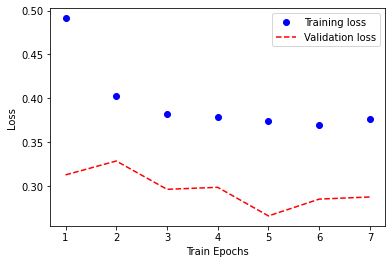

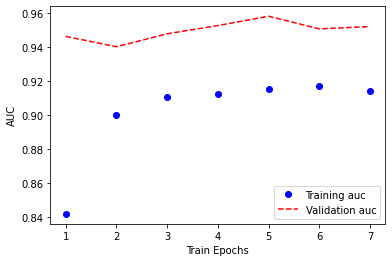

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

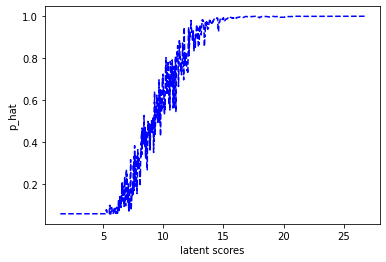

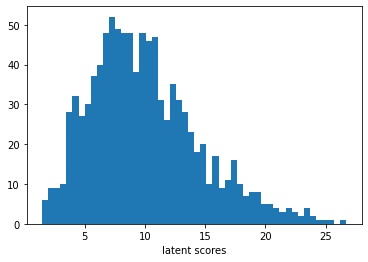

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

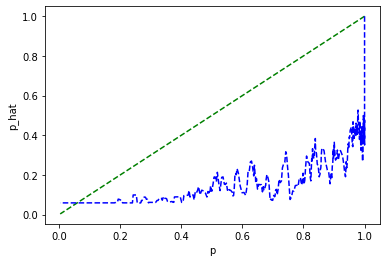

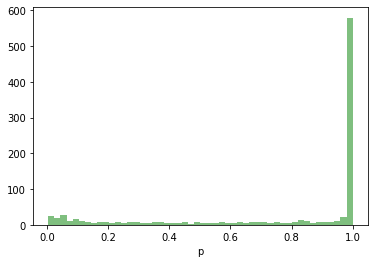

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

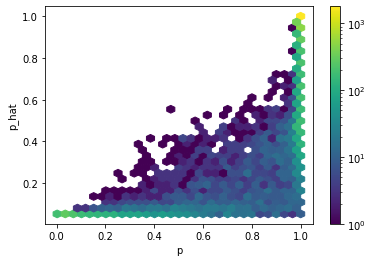

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

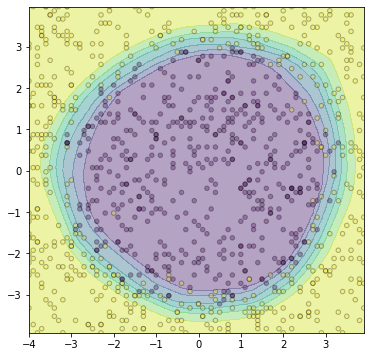

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.004,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.2708861231803894, 'epoch': 7},
 'best_auc': {'auc': 0.9546968340873718, 'epoch': 5},
 'best_accuracy': {'accuracy': 0.8813999891281128, 'epoch': 7},
 'model': <keras.engine.sequential.Sequential at 0x7f2fb0fb5a90>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.3116554915904999, 'epoch': 383},
  'best_auc': {'auc': 0.961861252784729, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.8748000264167786, 'epoch': 329}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.30976441502571106, 'epoch': 313},
  'best_auc': {'auc': 0.9647173285484314, 'epoch': 391},
  'best_accuracy': {'accuracy': 0.8753499984741211, 'epoch': 197}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.335135817527771, 'epoch': 218},
  'best_auc': {'auc': 0.964714527130127, 'epoch': 382},
  'best_accuracy': {'accuracy': 0.8560000061988831, 'epoch': 142}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.30591556429862976, 'epoch': 673},
  'best_auc': {'auc': 0.9628978967666626, 'epoch': 825},
  '

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25